# Example: 1D Oscillator - Part 3/3

- Author: Dr. Daning Huang
- Date: 07/14/2025

As the last part of the example, we show the set up for data transformations on the input and observation data.

Since Part 2 shows that KBF + weak form is a computationally economic choice, we will stick with this combination in this part.

## Preparation

Same drill like in Part 2.

In [1]:
import numpy as np
import torch

from dymad.models import KBF
from dymad.training import WeakFormTrainer
from dymad.utils import load_model, plot_trajectory, setup_logging, TrajectorySampler

In [2]:
B = 128   # Number of trajectories
N = 501   # Number of steps
t_grid = np.linspace(0, 5, N)

A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, z, u):               # Define the dynamics
    return (z @ A.T) + u
g = lambda t, z, u: z         # Define the observation

# Chirp input for training
config_chr = {
    "control" : {
        "kind": "chirp",
        "params": {
            "t1": 4.0,
            "freq_range": (0.5, 2.0),
            "amp_range": (0.5, 1.0),
            "phase_range": (0.0, 360.0)}}}

# Random Gaussian input for testing/generalization
config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}

# Generate data
sampler_chr = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_chr)
ts, zs, us, xs = sampler_chr.sample(t_grid, batch=B, save='./data/lti.npz')

sampler_gau = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)

Set up the options for weak form.

In [3]:
opt_wf = {
    "model": {
      "name" : 'lti_kbf_wf',
      "encoder_layers" : 1,
      "decoder_layers" : 1,
      "latent_dimension" : 32,
      "koopman_dimension" : 4,
      "const_term" : True,
      "activation" : "none",
      "weight_init" : "xavier_uniform",
      "input_order" : "cubic"
    },
    "training" : {
      "n_epochs": 500,
      "save_interval": 10,
      "load_checkpoint": False,
      "learning_rate": 5e-3,
      "decay_rate": 0.999,
      "reconstruction_weight": 1.0,
      "dynamics_weight": 1.0,
      "weak_form_params": {
        "N": 13,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2}
}}

## Data Transformation

We will run 3 cases, with transformations specified below:

- No transformation, as in the current `lti_model.yaml`
- `x` transforms by standard deviation, `u` transforms to [0, 1]
- `x` transforms by standard deviation **plus** a time delay of 1, `u` transforms by a time delay of 1

In the last case, a list is used for `x` to indicate the sequence of transform.

In [5]:
trans1 = {
  "transform_x": {"type": "identity"},
  "transform_u": {"type": "identity"}}

trans2 = {
  "transform_x": {"type": "scaler", "mode": "std"},
  "transform_u": {"type": "scaler", "mode": "01"}}

trans3 = {
  "transform_x": [
    {"type": "scaler", "mode": "std"},
    {"type": "delay", "delay": 1}],
  "transform_u": {"type": "delay", "delay": 1}}

Now Case 1 as a baseline.

The effect of data transformation can be seen in the figure generated on the fly, `lti_kbf_wf_prediction.png`.  Note the range of `x` and `u`.

In [6]:
config_path = 'lti_model.yaml'
opt_wf.update(**trans1)
setup_logging(config_path, mode='info', prefix='results')
trainer = WeakFormTrainer(config_path, KBF, config_mod=opt_wf)
trainer.train()

Then Case 2.  Clearly the ranges of `x` and `u` are different.

In [9]:
opt_wf.update(**trans2)
setup_logging(config_path, mode='info', prefix='results')
trainer = WeakFormTrainer(config_path, KBF, config_mod=opt_wf)
trainer.train()

Lastly, Case 3.  In this case, there are more "states" and "inputs" perceived by the model, due to the time delay.

In [10]:
opt_wf.update(**trans3)
setup_logging(config_path, mode='info', prefix='results')
trainer = WeakFormTrainer(config_path, KBF, config_mod=opt_wf)
trainer.train()

We also show the model prediction for Case 3.  The tiny change here is in `prd_wf`, where `t_data` is reduced by 1 step, due to the time delay.

The prediction function generated by `load_model` actually performs a transform and inverse transform on the given `x` and `u`, so that one does not need to manually perform the transformation for every new prediction.

In [12]:
ts, xs, us, ys = sampler_gau.sample(t_grid, batch=1, save=None)
x_data = xs[0]
t_data = ts[0]
u_data = us[0]

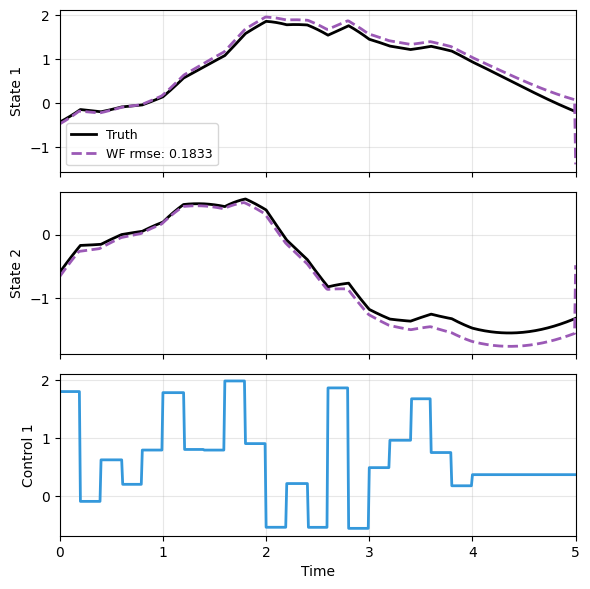

In [ ]:
mdl_wf, prd_wf = load_model(KBF, 'lti_kbf_wf.pt', 'lti_model.yaml', config_mod=opt_wf)

with torch.no_grad():
    weak_pred = prd_wf(x_data, u_data, t_data[:-1])

plot_trajectory(
    np.array([x_data, weak_pred]), t_data, "LTI",
    us=u_data, labels=['Truth', 'WF'], ifclose=False)